# Probability 

This is supporting material for chapters 13, 14, 15, 16 and parts of chapter 25. 

## Content

- Probability Distributions
    - Joint probability distributions
    - Inference using full joint distributions
- Bayesian Networks 
    - BayesNode
    - BayesNet
    - Exact Inference in Bayesian Networks 
        - Enumeration
        - Variable Elimination
    - Approximate Inference in Bayesian Networks 
        - Prior Sample
        - Rejection Sampling 
        - Likelihood Weighting
        - Gibbs Sampling
- Hidden Markov Models 
    - Inference in Hidden Markov Models 
        - Forward-Backward
        - Fixed Lag Smoothing
        - Particle Filtering 
- Monte Carlo Localization
- Decision Theoretic Agents
- Information Gathering Agents

### Probability Distributions 

The class ProbDist defines a discrete probability distribution. We name our random variable and then assign probabilities to the different values of the random variable. 

In [1]:
from probability import *
from utils import print_table 
from notebook import psource, pseudocode, heatmap

In [3]:
# view source for ProbDist Call
psource(ProbDist)

# create a ProbDist object 
p = ProbDist('Flip')
p['H'], p['T'] = 0.25, 0.75

The first parameter of the constructor varname has a default value of '?'. So if the name is not passed it defaults to '?'. The keyword argument freqs can be a dictionary of values of random variables. These are then normalized such that the probability values sum up to 1 using the normalize method. 

In [4]:
p = ProbDist(freqs = {'low': 125, 'medium': 375, 'high': 500})
p.varname
(p['low'], p['medium'], p['high'])

(0.125, 0.375, 0.5)

Besides the prob and varname, the obect also sepertely keeps track of all the values of the distribution in a list called values. Every time a new value is assigned a probability, it is appended to this list. This is done inside the _setitem_ method. 

In [5]:
p.values

['low', 'medium', 'high']

The distribution by default is not normalized if values are added incrementally. We can still force normalization by invoking the normalize method. 


In [10]:
p = ProbDist('Y')
p['cat'] = 50
p['dog'] = 114
p['mice'] = 64

print("regular:", (p['cat'], p['dog'], p['mice']))
p.normalize()
print("normalized: ", (p['cat'], p['dog'], p['mice']))
print("approximate values: ", p.show_approx())

regular: (50, 114, 64)
normalized:  (0.21929824561403508, 0.5, 0.2807017543859649)
approximate values:  cat: 0.219, dog: 0.5, mice: 0.281


### Joint Probability Distributions 

A probability model is completely determined by the joint distribution for all of the random variables. The probability module implements these as the class JointProbDist which inherits from the ProbDist class. This class specifies a discrete probability distribution over a set of variables.

Values for a joint distribution are ordered tuples in which each item corresponds to the value associated with a particular variable. For example, a joint distribution of X,Y where X,Y are ints may be something like (88, 99).

In [13]:
event = {'A': 10, 'B': 9, 'C': 8}
variables = ['C', 'A']
event_values(event, variables)

psource(JointProbDist)

In [14]:
# specify variables for joint dist 
variables = ['X', 'Y']
j = JointProbDist(variables)
j

P(['X', 'Y'])

In [16]:
# set some values 
j[1,1] = 0.2
j[dict(X = 0, Y = 1)] = 0.5 

print((j[1,1], j[0,1]))

print("X values", j.values('X'))

(0.2, 0.5)
X values [1, 0]


### Inference Using Full Joint Distributions 

In this section we use full joint distributions to calculate the posterior distribution given some evidence. We represent evidence by using a python dictionary with variables as dict keys and dict values as values. 

$p(X|e) = \alpha P(X, e) = \alpha \sum_y P(X, e, y)$

Where $\alpha$ is the normalizing factor, $X$ is the query variable, and $e$ is the evidence. We enumerate on the remaining variables $y$ for all possible combinations of $y$. 



In [17]:
# example from book
full_joint = JointProbDist(['Cavity', 'Toothache', 'Catch'])
full_joint[dict(Cavity=True, Toothache=True, Catch=True)] = 0.108
full_joint[dict(Cavity=True, Toothache=True, Catch=False)] = 0.012
full_joint[dict(Cavity=True, Toothache=False, Catch=True)] = 0.016
full_joint[dict(Cavity=True, Toothache=False, Catch=False)] = 0.064
full_joint[dict(Cavity=False, Toothache=True, Catch=True)] = 0.072
full_joint[dict(Cavity=False, Toothache=False, Catch=True)] = 0.144
full_joint[dict(Cavity=False, Toothache=True, Catch=False)] = 0.008
full_joint[dict(Cavity=False, Toothache=False, Catch=False)] = 0.576


In [18]:
psource(enumerate_joint)

In [21]:
# find P(toothache = true) through marginalization 
evidence = dict(Toothache = True)
variables = ['Cavity', 'Catch']
ans1 = enumerate_joint(variables, evidence, full_joint)
ans1

0.19999999999999998

In [23]:
# P(Cavity = True and Toothache = True)
evidence = dict(Cavity = True, Toothache = True)
variables = ['Catch']
ans2 = enumerate_joint(variables, evidence, full_joint)
ans2

0.12

We may be interested in the probability distribution of a particular variable conditioned on some evidence. This can involve doing calculations like above for each possible value of the variable. This has been implemented as enumerate_joint_ask which returns a probability distribution over the values of the variable X, given the observations e, in the joint distribution P. 

In [24]:
psource(enumerate_joint_ask)

In [25]:
# find p(cavity | toothache = True)
query_variable = 'Cavity'
evidence = dict(Toothache = True)
ans = enumerate_joint_ask(query_variable, evidence, full_joint)
print("True : False", (ans[True], ans[False]))

True : False (0.6, 0.39999999999999997)


### Bayesian Networks 

A Bayesian network is a representation of the joint probability distribution encoding a collection of conditional independence statements. 

In [27]:
psource(BayesNode)

Here is the example we will use: 

![](https://github.com/aimacode/aima-python/raw/3b0faac4256a58069e62d83c96b5e8b6a12e4f4c/images/bayesnet.png)

In [30]:
# create alarm node 
alarm_node = BayesNode('Alarm', ['Burglary', 'Earthquake'], 
                       {(True, True): 0.95,(True, False): 0.94, (False, True): 0.29, (False, False): 0.001})

# create John and Mary nodes
john_node = BayesNode('JohnCalls', ['Alarm'], {True: 0.90, False: 0.05})
mary_node = BayesNode('MaryCalls', 'Alarm', {(True, ): 0.70, (False, ): 0.01})

# burglary and earthquake nodes
burglary_node = BayesNode('Burglary', '', 0.001)
earthquake_node = BayesNode('Earthquake', '', 0.002)

In [31]:
# calculate p(JohnCalls = False | Alarm = True)
john_node.p(False, {'Alarm': True, 'Burglary': True})

0.09999999999999998

With all the information about nodes present, it is possible to construct a Bayes Network using BayesNet. 

In [32]:
psource(BayesNet)

In [33]:
# burglary is an instance of BayesNet corresponding to the above example 
burglary

BayesNet([('Burglary', ''), ('Earthquake', ''), ('Alarm', 'Burglary Earthquake'), ('JohnCalls', 'Alarm'), ('MaryCalls', 'Alarm')])

In [34]:
# see conditional probability table of burglary
burglary.variable_node('Alarm').cpt

{(True, True): 0.95,
 (True, False): 0.94,
 (False, True): 0.29,
 (False, False): 0.001}

### Exact Inference in Bayesian Networks 

A Bayes Network is a more compact representation of the full joint distribution and like the full joint distribution allows us to do inference. Exact algorithms don't scale well for larger networks. Approximate algorithms are described in the next section. 

In [36]:
# inference by enumeration
psource(enumerate_all)

psource(enumeration_ask)

In [37]:
# find p(burglary = True | JohnCalls = True, MaryCalls = True)
ans_dist = enumeration_ask('Burglary', {'JohnCalls': True, 'MaryCalls': True}, burglary)
ans_dist[True]

0.2841718353643929

### Variable Elimination

The enumeration algorithm can be improved substantially by eliminating repeated calculations. In enumeration we join the joint of all hidden variables. This is exponential in size for the number of hidden variables. Variable elimination employs interleaving join and marginalization. 

In [39]:
# factors
psource(make_factor)
psource(all_events)

in factor: 
- make_factor is used to create the cpt and variables that will be passed to the constructor of Factor. We use make_factor for each variable. It takes in the arguments:
    - var: the particular variable
    - e: the evidence
    - bn: the bayes network

The all_events function is a recursive generator function which yields a key for the original cpt which is part of the node. This works by extending evidence related to the node, thus all output from all_events only includes events that support the evidence. 

In [40]:
# try it out 
f5 = make_factor('MaryCalls', {'JohnCalls': True, 'MaryCalls': True}, burglary)
f5

In [42]:
# conditional probability table
print("CPT: ", f5.cpt)

# variables
print("Variables: ", f5.variables)

CPT:  {(True,): 0.7, (False,): 0.01}
Variables:  ['Alarm']


In [43]:
# p(MaryCalls | Alarm = True)
new_factor = make_factor('MaryCalls', {'Alarm': True}, burglary)
new_factor.cpt

{(True,): 0.7, (False,): 0.30000000000000004}

Operations on Factors

We are interested in two kinds of operations on factors. Pointwise product is used to create joint distributions and summing out is used for marginalization

In [45]:
psource(Factor.pointwise_product)

psource(Factor.sum_out)

In [46]:
# sum_out uses both Factor.sum_out and pointwise_product to eliminate a particular variable from all factors by summing over its valuess 
psource(sum_out)

Elimination Ask

The key idea with this algorithm is that we eliminate the hidden variables by interleaving joining and marginalization. The algorithm creates factors out of Bayes Nodes in reverse order and eliminates hidden variables using sum_out. Finally, it takes a pointwise product of all factors and normalizes. 

In [47]:
psource(elimination_ask)

In [48]:
# p(burglary = True | JohnCalls = True, MaryCalls = True)
elimination_ask('Burglary', dict(JohnCalls = True, MaryCalls = True), burglary).show_approx()

'False: 0.716, True: 0.284'

#### Runtime Comparison

Lets see how the runtimes of these two algorithms compare. We expect variable elimination to outperform enumeration.

In [52]:
%timeit enumeration_ask('Burglary', dict(JohnCalls = True, MaryCalls = True), burglary).show_approx()

196 µs ± 11.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [51]:
%timeit elimination_ask('Burglary', dict(JohnCalls = True, MaryCalls = True), burglary).show_approx()

454 µs ± 3.42 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


We observe that the enumeration ask is much faster, in contrast with the jupyter notebooks results of enumeration: 367 and elimination: 241

### Approximate Inference in Bayesian Networks 

Exact inference fails to scale for very large and complex Bayesian networks. This section covers implementation of randomized sampling algorithms (Monte Carlo Methods).

In [53]:
psource(BayesNode.sample)

BayesNode's sample method samples from the distribution for the variable conditioned on event's values for parent_variables. It returns True or False at random according to the conditional probability given its parents. 

### Prior Sampling 

The idea of prior sampling is to sample from the Bayesian network in a topological order.
Traversing the graph in topological order is important. For example, given:

![](https://github.com/aimacode/aima-python/raw/3b0faac4256a58069e62d83c96b5e8b6a12e4f4c/images/sprinklernet.jpg)

there are two possible topological orderings for this particular directed acyclic graph:

1. Cloudy -> Sprinkler -> Rain -> Wet Grass
2. Cloudy -> Rain -> Sprinkler -> Wet Grass

In [54]:
psource(prior_sample)

In [55]:
# find p(rain = True) by taking 1000 samples from the network
# set number of samples
N = 1000
# grab observations
all_observations = [prior_sample(sprinkler) for x in range(N)]
# filter for observations where rain = true
rain_true = [observation for observation in all_observations if observation['Rain'] == True]
# find p(rain = true)
answer = len(rain_true) / N
print(answer)

0.508


To evaluate a conditional distribution we can use a two-step filtering process. 
First we seperate out the variables that are consistent with the evidence. 
Then for each value of the query variable, we can find the probabilities

In [56]:
# find p(rain = true and cloudy = true)
rain_and_cloudy = [observation for observation in rain_true if observation['Cloudy'] == True]
answer = len(rain_and_cloudy) / len(rain_true)
print(answer)

0.8169291338582677


### Rejection Sampling 

First we generate samples from the prior distribution specified by the network. Then it rejects all those who do not match the evidence. Rejection sampling is advantageous only when we know the query beforehand. While prior sampling generally works for any query, it might fail in some scenarios. 

In [58]:
psource(rejection_sampling)
psource(consistent_with)

In [59]:
# p(cloudy = true | rain = true)
p = rejection_sampling('Cloudy', dict(Rain = True), sprinkler, 1000)
p[True]

0.8181818181818182

#### Likelihood Weighting

Rejection sampling takes a long time to run when the probability of findig consistent evidence is low. It is also slow for larger networks and more evidence variables. Rejection sampling also tends to reject a lot of samples if our evidence consists of a large number of variables. Likelihood Weighting solves this by fixing the evidence and then using weights to make sure that our overall sampling is still consistent.

In [62]:
psource(weighted_sample)

weighted_sample samples an event from a Bayesian network that is consistent with evidence e and returns the event weight, the likelihood that the event accords to the evidence. The weight is obtained by multiplying $p(x_i | parents(x_i))$ for each node in the evidence. We set the values of event = evidence at the start of the function.

In [64]:
weighted_sample(sprinkler, dict(Rain = True))

({'Rain': True, 'Cloudy': True, 'Sprinkler': False, 'WetGrass': True}, 0.8)

Likelihood weighting implements the algorithm in order to solve our inference problem. The code is similar to rejection_sampling but instead of adding one for each sample we add the weight obtained from weighted_sampling.

In [63]:
psource(likelihood_weighting)

In [65]:
likelihood_weighting('Cloudy', dict(Rain = True), sprinkler, 200).show_approx()

'False: 0.261, True: 0.739'

### Gibbs Sampling 

In likelihood sampling, it is possible to obtain low weights in cases where the evidence variables reside at the bottom of the Bayesian network. This can happen because influence only propagates downwards in likelihood sampling. Gibbs sampling solves this.

In [66]:
psource(gibbs_ask)

In [67]:
gibbs_ask('Cloudy', dict(Rain = True), sprinkler, 200).show_approx()

'False: 0.235, True: 0.765'

In [69]:
# prior sampling runtime analysis
%timeit all_observations = [prior_sample(sprinkler) for x in range(1000)]
rain_true = [observation for observation in all_observations if observation['Rain'] == True]
len([observation for observation in rain_true if observation['Cloudy'] == True]) / len(rain_true)


18.3 ms ± 899 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


0.8169014084507042

In [70]:
# rejection sampling 
%timeit rejection_sampling('Cloudy', dict(Rain = True), sprinkler, 1000)

22.3 ms ± 522 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [71]:
# likelihood weighting 
%timeit likelihood_weighting('Cloudy', dict(Rain = True), sprinkler, 200)

3.57 ms ± 14.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [72]:
# gibbs sampling
%timeit gibbs_ask('Cloudy', dict(Rain = True), sprinkler, 200)

18.1 ms ± 1.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Hidden Markov Models

Often we need to carry out probabilistic inference on temporal data or a sequence of observations where the order of observations matter. We require a model similar to a Bayesian network, but one that grows over time to keep up with the latest evidences. 

A Markov model is basically a chain structured Bayesian network in which there is one state for each time step and each node has an identical probability distribution. The first node has a prior distribution which models the initial state of the process. A state in a Markov model only depends on the previous state and the latest evidence and not on the states before it. 

A hidden Markov model or HMM is a special case of a Markov model in which the state of the process is described by a single discrete random variable. The possible values of the variable are the possible states of the world. If we want to model a process with two or more state variables, we can still fit it into the HMM framework by redefining our state variables as a single megavariable.

In [73]:
psource(HiddenMarkovModel)

In [74]:
# instantiate HMM
umbrella_transition_model = [[0.7, 0.3], [0.3, 0.7]]
umbrella_sensor_model = [[0.9, 0.2], [0.1, 0.8]]
hmm = HiddenMarkovModel(umbrella_transition_model, umbrella_sensor_model)

# return a list of the conditional probabilities 
hmm.sensor_dist(ev = True)

[0.9, 0.2]

Now that we have an HMM object, we wish to compute the belief $B_t(x) = P(X_t | U_{1:t})$, given evidence U are each time step t. 

The basic inference tasks that must be solved are: 

1. Filtering: Computing the posterior probability distribution over the most recent state, given all the evidence up to the current time step. 
2. Prediction: Computing the posterior probability distribution over the future state
3. Smoothing: Computing the posterior probability distribution over a past state. Smoothing provides a better estimation as it incorporates more evidence. 
4. Most likely explanation: Finding the most likely sequence of states for a given observation
5. Learning: The transition and sensor models can be learnt, if not yet known

There are 3 primary methods for inference in HMMs

1. The Forward-Backward Algorithm
2. Fixed Lag Smoothing
3. Particle Filtering 

### The Forward-Backward Algorithm

This works for all Markov models, not just HMMs. In the filtering task we are given evidence U in each time t and we wish to compute the belief. We can think of it as a 3 step process: 

1. In every step we start with the current belief
2. We update it for time
3. We update it for evidence 

The forward algorithm performs steps 2 and 3 at once. It updates (or reweights) the initial belief using the transition and the sensor model.

In [75]:
psource(forward)

In [76]:
# solve raining inference 
umbrella_prior = [0.5, 0.5]
belief_day_1 = forward(hmm, umbrella_prior, ev = True)
print('The probability of rain on day 1 is {:.2f}'.format(belief_day_1[0]))

The probability of rain on day 1 is 0.82


In [78]:
# in day 2 our belief is updated by day 1
belief_day_2 = forward(hmm, belief_day_1, ev = True)
print('The probability of rain on day 2 is {:.2f}'.format(belief_day_2[0]))

The probability of rain on day 2 is 0.88


In the smoothing part we are interested in computing the distribution over past states given evidence up to the present. Assume that we want to compute the distribution for time k, for $0 \leq k \leq t$. This computation can be divided into 2 parts: 

1. The forward message will be computed by filtering forward from 1 to k
2. The backward message can be computed by a recursive process that runs from k to t

In [79]:
psource(backward)

In [80]:
b = [1, 1]
backward(hmm, b, ev = True)

[0.6272727272727272, 0.37272727272727274]

In [81]:
pseudocode('Forward-Backward')

### AIMA3e
__function__ FORWARD-BACKWARD(__ev__, _prior_) __returns__ a vector of probability distributions  
&emsp;__inputs__: __ev__, a vector of evidence values for steps 1,&hellip;,_t_  
&emsp;&emsp;&emsp;&emsp;&emsp;_prior_, the prior distribution on the initial state, __P__(__X__<sub>0</sub>)  
&emsp;__local variables__: __fv__, a vector of forward messages for steps 0,&hellip;,_t_    
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;__b__, a representation of the backward message, initially all 1s  
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;__sv__, a vector of smoothed estimates for steps 1,&hellip;,_t_  

&emsp;__fv__\[0\] &larr; _prior_  
&emsp;__for__ _i_ = 1 __to__ _t_ __do__  
&emsp;&emsp;&emsp;__fv__\[_i_\] &larr; FORWARD(__fv__\[_i_ &minus; 1\], __ev__\[_i_\])  
&emsp;__for__ _i_ = _t_ __downto__ 1 __do__  
&emsp;&emsp;&emsp;__sv__\[_i_\] &larr; NORMALIZE(__fv__\[_i_\] &times; __b__)  
&emsp;&emsp;&emsp;__b__ &larr; BACKWARD(__b__, __ev__\[_i_\])  
&emsp;__return__ __sv__

---
__Figure ??__ The forward\-backward algorithm for smoothing: computing posterior probabilities of a sequence of states given a sequence of observations. The FORWARD and BACKWARD operators are defined by Equations (__??__) and (__??__), respectively.

In [82]:
umbrella_prior = [0.5, 0.5]
prob = forward_backward(hmm, ev = [T, T], prior = umbrella_prior)
print ('The probability of raining in Day 0 is {:.2f} and in Day 1 is {:.2f}'.format(prob[0][0], prob[1][0]))

The probability of raining in Day 0 is 0.65 and in Day 1 is 0.88


### Fixed Lag Smoothing 

Since we use a matrix formulation, we can optimize online smoothing with a fixed lag. The algorithm applies forward and optimizes the smoothing step by using specific equations (don't want to write, check the book). This optimization can be achieved only because of the HMM matrix formulation. 

In [83]:
psource(fixed_lag_smoothing)

In [85]:
# fixed lag smoothing inference 
umbrella_transition_model = [[0.7, 0.3], [0.3, 0.7]]
umbrella_sensor_model = [[0.9, 0.2], [0.1, 0.8]]
hmm = HiddenMarkovModel(umbrella_transition_model, umbrella_sensor_model)

# given evidence T,F,T,F,T we want to calc the dist for the fourth day with a lag of 2 days 
e_t = F
evidence = [T, F, T, F, T]
fixed_lag_smoothing(e_t, hmm, d = 2, ev = evidence, t = 4)

[0.1111111111111111, 0.8888888888888888]

In [86]:
e_t = T
evidence = [T, F, T, F, T]
fixed_lag_smoothing(e_t, hmm, d = 2, ev = evidence, t = 4)

[0.9938650306748466, 0.006134969325153394]

In [88]:
# we cannot calculate probability distributions when t is less than d 
fixed_lag_smoothing(e_t, hmm, d = 5, ev = evidence, t = 4)

### Particle Filtering 

The filtering problem is mostly used for problems with large or continuous state spaces. In this method, instead of keeping track of the probability distribution, we will drop particles in a similar proportion at the required regions. The internal representation of this distribution is usually a list of particles with coordinates in the state-space. A particle is just a new name for a sample. 

We can divide particle filtering into four steps: 

1. Initialization: If we have some idea for the prior probability distribution, we drop the initial particles accordingly, or else we just drop them uniformly over the state space.

2. Forward pass: As time goes by and measurements come in, we move the selected particles into the grid square that make the most sense in terms of representing the distribution that we are trying to track. When time goes by, we just loop through all of our particles and try to simulate what could happen to each one of them by sampling its next position from the transition model. This is like prior sampling - samples' frequencies reflect the transition probabilities. If we have enough samples we are pretty close to exact values. We work through a list of particles, one particle at a time. 

3. Reweight: As observations come in, don't sample the observations. Fix them and downweight the samples based on the evidence just like in likelihood weighting. 

4. Resample: rather than tracking weighted samples, we resample. We choose from our weighted sample distribution as many times as the number of particles we initially had and we replace these particles too so that we have a constant number of particles. This is equivalent to normalizing the distribution. The samples with low weight are rarely chosen in the new distribution after resampling. This newer set of particles after resampling is in some sense more representative of the actual distribution and so we are better allocating our computational cycles. 

In [89]:
psource(particle_filtering)

In [90]:
# use particle filtering on the tiny umbrella HMM
umbrella_transition_model = [[0.7, 0.3], [0.3, 0.7]]
umbrella_sensor_model = [[0.9, 0.2], [0.1, 0.8]]
hmm = HiddenMarkovModel(umbrella_transition_model, umbrella_sensor_model)
particle_filtering(T, 10, hmm)

['A', 'A', 'A', 'A', 'A', 'A', 'B', 'A', 'A', 'A']

In [91]:
particle_filtering(T, 10, hmm)

['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A']

### Monte Carlo Localization 

In robotics, particle filtering is used for robot localization. Localization is the problem of finding out where things are, for example the position of a robot in continuous state space. 

Monte Carlo Localization is an algorithm for robots to localize using a particle filter. Given a map of the environment, the algorithm estimates the position and orientation of a robot as it moves and senses the environment.


In [92]:
psource(monte_carlo_localization)

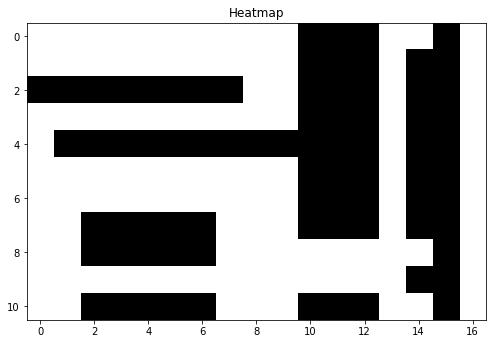

In [93]:
# define 2D map to run monte carlo localization on
m = MCLmap([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0],
            [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0],
            [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0],
            [0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0],
            [0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
            [0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0]])

heatmap(m.m, cmap='binary')

In [94]:
# define the motion model 
def P_motion_sample(kin_state, v, w): 
    '''
    sample from possible kinematic states. 
    Returns from a single element distribution (no uncertainty in motion)
    '''
    pos = kin_state[:2]
    orient = kin_state[2]
    
    # for simplicity the robot first rotates and then moves 
    orient = (orient + w)%4
    for _ in range(orient):
        v = (v[1], -v[0])
    pos = vector_add(pos, v)
    return pos + (orient, )

# define the sensor model 
def P_sensor(x, y):
    '''
    conditional probability for sensor reading
    '''
    if x == y:
        return 0.8
    elif abs(x - y) <= 2:
        return 0.05
    else:
        return 0

GRID:
  0   0   6    70   102    8     0   0   0   0   0   0   0   0   0   0   0
  0   0   0     0     4    0   143   9   0   0   0   0   0   0   0   0   0
  0   0   0     0     0    0     0   0   0   0   0   0   0   0   0   0   0
  0   0   1     4     6    8     7   1   0   0   0   0   0   0   0   0   0
  0   0   0     0     0    0     0   0   0   0   0   0   0   0   0   0   0
  0   0   1   100   118    6     0   0   0   0   0   0   0   0   0   0   0
  0   0   0     0     8   36   163   0   0   0   0   0   0   0   0   0   0
122   0   0     0     0    0     0   0   0   0   0   0   0   0   0   0   0
 64   0   0     0     0    0     0   2   0   1   0   0   0   0   0   0   0
  0   0   0     0     0    9     1   0   0   0   0   0   0   0   0   0   0
  0   0   0     0     0    0     0   0   0   0   0   0   0   0   0   0   0


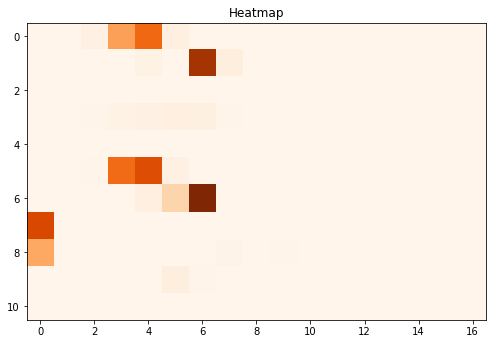

In [97]:
# initialize variables 
a = {'v': (0, 0), 'w': 0}
z = (2, 4, 1, 6)

# run monte carlo with these parameters 
S = monte_carlo_localization(a, z, 1000, P_motion_sample, P_sensor, m)

# plot values for the sample distribution S
grid = [[0] * 17 for _ in range(11)]
for x, y, _ in S:
    if 0 <= x < 11 and 0 <= y < 17:
        grid[x][y] += 1
print("GRID:")
print_table(grid)
heatmap(grid, cmap='Oranges')

GRID:
0   0   0   0   0   0   0      0   0   0   0   0   0   0   0   0   0
0   0   0   0   0   0   0      0   0   0   0   0   0   0   0   0   0
0   0   0   0   0   0   0      0   0   0   0   0   0   0   0   0   0
0   0   0   0   0   0   0      0   0   0   0   0   0   0   0   0   0
0   0   0   0   0   0   0      0   0   0   0   0   0   0   0   0   0
0   0   0   0   0   0   0      0   0   0   0   0   0   0   0   0   0
0   0   0   0   0   0   0   1000   0   0   0   0   0   0   0   0   0
0   0   0   0   0   0   0      0   0   0   0   0   0   0   0   0   0
0   0   0   0   0   0   0      0   0   0   0   0   0   0   0   0   0
0   0   0   0   0   0   0      0   0   0   0   0   0   0   0   0   0
0   0   0   0   0   0   0      0   0   0   0   0   0   0   0   0   0


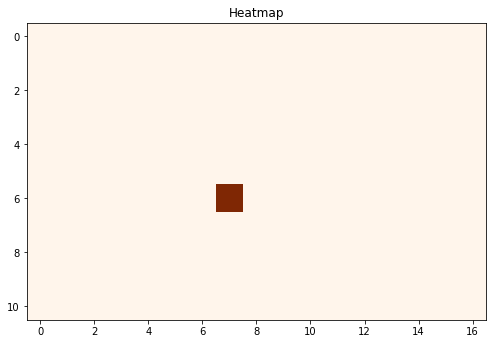

In [96]:
# scenario 2
a = {'v': (0, 1), 'w': 0}
z = (2, 3, 5, 7)
S = monte_carlo_localization(a, z, 1000, P_motion_sample, P_sensor, m, S)
grid = [[0]*17 for _ in range(11)]
for x, y, _ in S:
    if 0 <= x < 11 and 0 <= y < 17:
        grid[x][y] += 1
print("GRID:")
print_table(grid)
heatmap(grid, cmap='Oranges')

### Decision Theoretic Agent 

To make chooses between various possible plans in a certain situation in a given environment, an agent must have a preference between the possible outcomes of the various plans. 

Utility theory is used to represent and reason with preferences. The agent prefers states with a higher utility. While constructing multi-agent systems, one major element in the design is the mechanism the agents use for making decisions about which actions to adopt in order to achieve their goals. What is usually required is a mechanism which ensures that the actions adopted lead to benefits for both individual agents, and for the community of which they are a part. 

Preferences, as expressed by utilities, are combined with probabilities in the general theory of rational decisions called decision theory. 

In [99]:
psource(DTAgentProgram)
psource(InformationGatheringAgent)